In [1]:
import imgtda
from imgtda import standard_analysis as sa
from imgtda import computer_vision as cv

import numpy as np
import pandas as pd
from scipy import misc
from skimage import morphology as morph
from skimage import measure
import scipy
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage as ndi
from PIL import Image
import PIL

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation

%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 10.0) 

import warnings
warnings.filterwarnings('ignore')

## Set Up Project

In [2]:
myproject = imgtda.Project

myproject['directory'] = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast'
myproject['bmp_format'] = 'g21flow/bmps/%06d.bmp'
myproject['pd_sub_format'] = 'g21flow/pd_sub/%06d.csv'
myproject['pd_sup_format'] = 'g21flow/pd_sup/%06d.csv'
myproject['additional_data'] = {'lyap_format':'g21per/bmps_abs_val/%05d.bmp',
                                'delta':10,
                                'lyap_out_format':'g21per/bmps_abs_val_smooth_6/%05d.bmp',
                                'lyap_pdsub_format':'g21per/pd_sub_smooth_6/%05d.csv'}


## Utility Functions

In [3]:
def load_image_data(project, idx):
    
    im = imgtda.image.load_image_from_file(project['directory'] + "/" + (project['bmp_format'] % idx))
    im.load_sublevel_pd(project['directory'] + "/" + (project['pd_sub_format'] % idx))
    im.load_superlevel_pd(project['directory'] + "/" + (project['pd_sup_format'] % idx))
    return im

def load_lyap_data(project, idx):
    
    lyap = misc.imread(project['directory'] + "/" + (project['additional_data']['lyap_format'] % idx))
    return lyap

def load_lyap_pd_data(project, idx):
    
    lyap = pd.DataFrame(pd.read_csv(project['directory'] + "/" + (project['additional_data']['lyap_pdsub_format'] % idx)))
    return lyap

def cropping_region():

    c = np.zeros((421,421))
    centerx = 210
    centery = 210
    radius=200
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            if ((i-centerx)**2 + (j-centery)**2 < radius**2):
                c[i,j] = 1
    c = c.astype(np.int)
    return c


def get_image_saddle_points(im, lowercutoff, uppercutoff, delta):
    
    # Generate persistent homology defect matrix
    ph_lower_saddles = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==0) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['death']>=lowercutoff) & (im.persistence_diagrams['sub']['death']<=127)][['d_x','d_y']]
    ph_lower_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==1) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['birth']>=lowercutoff) & (im.persistence_diagrams['sub']['birth']<=127)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_lower_saddles = pd.concat([ph_lower_saddles, ph_tmp])

    ph_upper_saddles = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==0) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['death']>=127) & (im.persistence_diagrams['sup']['death']<=uppercutoff)][['d_x','d_y']]
    ph_upper_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==1) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['birth']>=127) & (im.persistence_diagrams['sup']['birth']<=uppercutoff)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_upper_saddles = pd.concat([ph_upper_saddles, ph_tmp])
    
    saddle_points = pd.concat([ph_lower_saddles, ph_upper_saddles])
    
    saddle_matrix = np.zeros(im.bmp.shape)
    saddle_matrix[saddle_points['row'], saddle_points['col']] = 1

    return saddle_matrix


def get_image_plumes(im, lowercutoff, uppercutoff, delta):
    
    # Generate persistent homology defect matrix
    ph_lower_plumes = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==1) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['death']<=uppercutoff) & (im.persistence_diagrams['sub']['birth']<=127)][['d_x','d_y']]
    ph_lower_plumes.columns = ['col', 'row']

    ph_upper_plumes = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==1) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['birth']>=127) & (im.persistence_diagrams['sup']['death']>=lowercutoff)][['d_x','d_y']]
    ph_upper_plumes.columns = ['col', 'row']
    
    plumes = pd.concat([ph_lower_plumes, ph_upper_plumes])
    
    plume_matrix = np.zeros(im.bmp.shape)
    plume_matrix[plumes['row'], plumes['col']] = 1

    return plume_matrix

def get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta):

    im = load_image_data(myproject, idx)
    
    im.generate_orientation_field(sigma,1)
    im.orientation_fields[sigma].topological_defects_list = sa.topological_defect_array_to_dataframe(im.orientation_fields[sigma].topological_defects)
    im.saddle_points = get_image_saddle_points(im, lowercutoff, uppercutoff, delta)
    im.plumes = get_image_plumes(im, lowercutoff, uppercutoff, delta)

    return im

def generate_smoothed_lyap(idx, lyap_sigma, lyap):
    
    lyap = scipy.ndimage.filters.gaussian_filter(lyap, sigma=lyap_sigma)*2.
    lyap[lyap>=1.] = 1.
    
    lyap = (lyap*255.).astype(np.int)
    
    c = cropping_region()
    lyap = np.multiply(lyap, c)
    
    misc.imsave(myproject['directory'] + "/" + (myproject['additional_data']['lyap_out_format'] % idx), lyap)
    
    return 1
    

## Preprocess data for animation

### Functions for processing

In [4]:
def get_td_velocities(current, prior, distance_cutoff):
    
    types = [1., -1.]
    
    current['velocity'] = distance_cutoff
    current['matchedid'] = -1
    

    if not prior.empty:
        for t in types:
            type_matches = cv.match_points(current.ix[current.type == t,['row', 'col']], prior.loc[prior.type == t,['row', 'col']], distance_cutoff)
            current.ix[current.type==t, 'velocity'] = type_matches[:,1]
            current.ix[current.type==t, 'matchedid'] = type_matches[:,0].astype(np.int)
            
    return current

def get_defect_regions(im, sigma, radius, wn_cutoff, wn_cutoff_low, prev_td, distance_cutoff, lyap_pd, lyap_vec, prev_img, prev2_img):
    
    # Return a list rather than a matrix for scatter plot with varying alphas.
    #topological_defects_dilated = morph.binary_dilation(im.orientation_fields[sigma].topological_defects, morph.disk(radius))
    
    saddle_points_dilated = morph.binary_dilation(im.saddle_points, morph.disk(radius))
    plumes_dilated = morph.binary_dilation(im.plumes, morph.disk(radius))
    all_ph_dilated = ((saddle_points_dilated+plumes_dilated)>0).astype(np.int)
    large_wn = (im.local_wavenumber >= wn_cutoff).astype(np.int)
    small_wn = (im.local_wavenumber <= wn_cutoff_low).astype(np.int)
        
    td_with_velocities = get_td_velocities(im.orientation_fields[sigma].topological_defects_list, prev_td, distance_cutoff)
    
    local_maxi = np.zeros(im.bmp.shape)
    local_maxi[lyap_pd['d_y'], lyap_pd['d_x']] = 1
    local_maxi = np.multiply(local_maxi, lyap_vec)
    
    lyap_maxima = np.asarray([ (i,j,local_maxi[i,j]) for (i,j) in np.argwhere(local_maxi)])
    lyap_maxima = pd.DataFrame(lyap_maxima, columns=['row', 'col', 'value'])
    
    l1_diff = np.abs(im.bmp - prev_img).astype(np.float)
    l2_diff = np.abs(np.abs(im.bmp - prev_img).astype(np.float) - np.abs(prev2_img - prev_img).astype(np.float))

    return (td_with_velocities, all_ph_dilated, large_wn, small_wn, lyap_vec, lyap_maxima, l1_diff, l2_diff)

def compose(f, x, n):
    if n == 0:
        return x
    return compose(f, f(x), n - 1)

def log_plus_one(x):
    return np.log10(10.*x+1)

def compute_derivative(images, derivative):
    if derivative == 1:
        return abs(images[0] - images[1])  
    else: 
        return compute_derivative([compute_derivative(images,derivative-1), compute_derivative(images[1:],derivative-1)],1)


### Processing code

1000


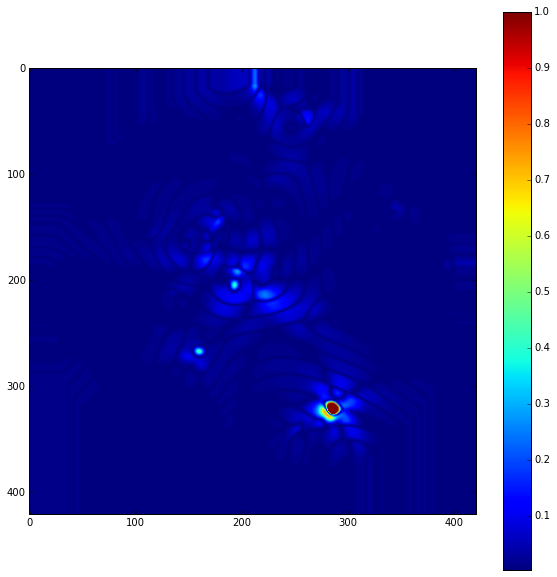

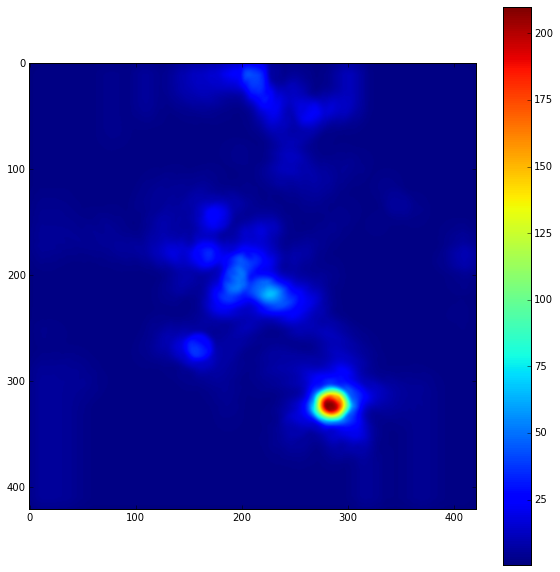

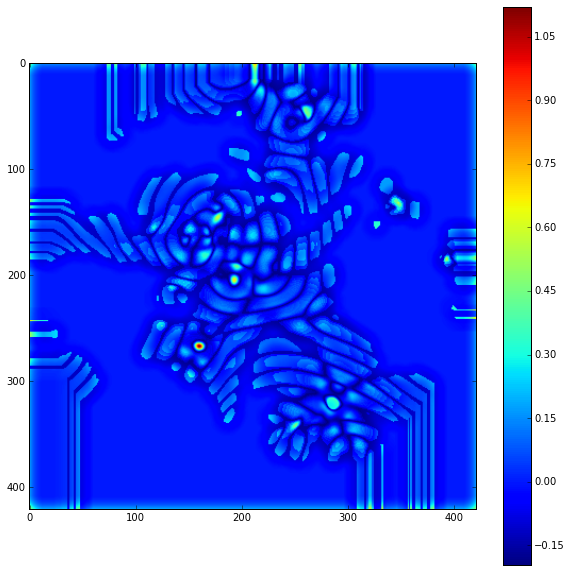

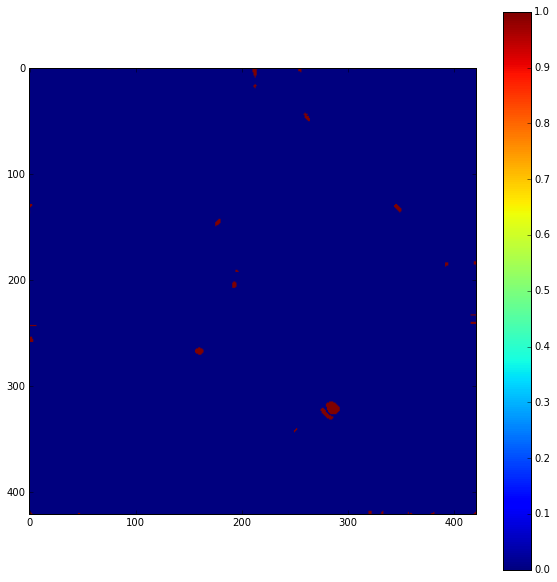

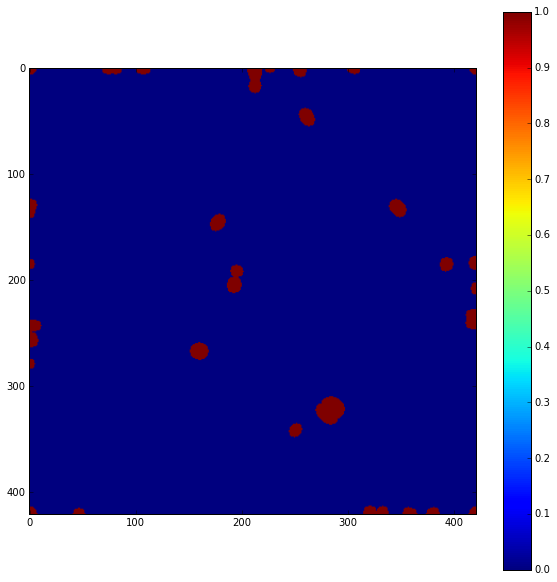

NameError: name 'lyap_delta' is not defined

In [9]:
process_range = range(1000, 1001)

sigma = 3
radius = 10
lowercutoff = 45
uppercutoff = 200
delta = 10
wn_cutoff = 3.
wn_cutoff_low = 1.6
distance_cutoff = 7.

lyap_cutoff = 0.5
lyap_blur_radius = 12
lyap_diff_cutoff = 0.4

l1_cutoff = 10.
l2_cutoff = 10.

animation_data = {}
prev_td = pd.DataFrame([], columns=['row', 'col', 'type'])

for idx in process_range:
    
    print idx
    
    im = get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta)
    im.local_wavenumber = sa.emb_wavenumber(im.bmp.astype(np.float), "difference", 10)*10.
    
    if idx == process_range[0]:
        prev_img = im.bmp.copy()
        prev2_img = im.bmp.copy()
    
    lyap = load_lyap_data(myproject, idx)
    lyap = lyap.astype(np.float)/255.
    
    plt.imshow(lyap)
    plt.colorbar()
    plt.show()
    
    # Compute the average pixel value for each local region (blur with given radius)
    lyap_average = lyap.copy()
    kernel = np.zeros((lyap_blur_radius*2, lyap_blur_radius*2))
    kernel[lyap_blur_radius, lyap_blur_radius] = 1.
    kernel = morph.binary_dilation(morph.disk(lyap_blur_radius))
    lyap_average = scipy.ndimage.convolve(lyap_average, kernel, mode='constant', cval=0.0)
    
    plt.imshow(lyap_average)
    plt.colorbar()
    plt.show()
    
    lyap_diff = lyap - lyap_average/np.sum(kernel)
    
    
#     plt.imshow(lyap)
#     plt.colorbar()
#     plt.show()
    
#     plt.imshow(lyap_average)
#     plt.colorbar()
#     plt.show()
    
    divisor = lyap_average.copy()
    divisor[divisor <= 0.1] = 1
    lyap_diff = np.divide(lyap_diff, divisor)*100.
    
    plt.imshow(lyap_diff)
    plt.colorbar()
    plt.show()
    
    lyap_diff = lyap_diff + (lyap>=lyap_cutoff).astype(np.int)
    lyap_diff = (lyap_diff >= lyap_diff_cutoff).astype(np.int)
    
    plt.imshow(lyap_diff)
    plt.colorbar()
    plt.show()
    
    lyap_diff = morph.binary_dilation(lyap_diff, morph.disk(5))
    
    plt.imshow(lyap_diff)
    plt.colorbar()
    plt.show()
    
#     plt.imshow(lyap_diff)
#     plt.colorbar()
#     plt.show()
    
    
    
#     lyap = compose(log_plus_one, scipy.ndimage.filters.gaussian_filter(lyap, sigma=15), 3)
#     lyap = scipy.ndimage.filters.gaussian_filter(lyap, sigma=lyap_sigma)*2.
    lyap[lyap>=lyap_cutoff] = 1.

    lyap_pd = load_lyap_pd_data(myproject, idx)
    lyap_pd = lyap_pd.loc[(lyap_pd['dim']==1) & (lyap_pd['death'] - lyap_pd['birth'] >= lyap_delta)]
    
    # Crop everything into a circular region
    c = cropping_region()
    im.bmp = np.multiply(im.bmp, c)
    im.orientation_fields[sigma].topological_defects = np.multiply(im.orientation_fields[sigma].topological_defects, c)
    im.saddle_points = np.multiply(im.saddle_points, c)
    im.plumes = np.multiply(im.plumes, c)
    lyap = np.multiply(lyap, c)
    im.local_wavenumber[c == 0] = np.median(im.local_wavenumber[c == 1])
    lyap_diff = np.multiply(lyap_diff, c)
    
    # Get the stuff to plot
    (td, ph, wn, wn_low, lyap, lyap_peaks, l1_diff, l2_diff) = get_defect_regions(im, sigma, radius, wn_cutoff, wn_cutoff_low, prev_td, distance_cutoff, lyap_pd, lyap, prev_img, prev2_img)
    contours = measure.find_contours(im.bmp, 127.)
    
#     plt.imshow(np.multiply(l1_diff, c))
#     plt.colorbar()
#     plt.show()
    
#     plt.imshow(np.multiply(l2_diff, c))
#     plt.colorbar()
#     plt.show()
    
    l1_diff = (l1_diff>=l1_cutoff).astype(np.int)
    
    l2_diff = (l2_diff>=l2_cutoff).astype(np.int)
    l2_diff = morph.binary_dilation(l2_diff, morph.disk(5))
    l2_diff = np.multiply(l2_diff, c)
    
    animation_data[idx] = {'td': td, 'ph': ph, 'wn': wn, 'wn_low': wn_low, 'contours': contours, 'lyap': lyap, 'lyap_peaks': lyap_peaks, 'l1_diff': l1_diff, 'l2_diff': l2_diff, 'lyap_diff': lyap_diff}
    
    prev_td = im.orientation_fields[sigma].topological_defects_list.copy()
    
    prev2_img = prev_img.copy()
    prev_img = im.bmp.copy()
    
    del prev_td['velocity']
    del prev_td['matchedid']

## Animation code

In [12]:
def update_plot(ax, plot_data):
    
    plot_layers = []
    
#     matched_tds = plot_data['td'].loc[plot_data['td']['matchedid']>-1]
#     unmatched_tds = plot_data['td'].loc[plot_data['td']['matchedid']==-1]
    
#     # Matched topological defects
#     alphas_matched = matched_tds['velocity']
#     tda_colors_matched = np.zeros((matched_tds.shape[0],4))
#     tda_colors_matched[:,1] = 1
#     tda_colors_matched[:,2] = 1
#     tda_colors_matched[:,3] = (alphas_matched/distance_cutoff)*.6
#     plot_layers.append( [ax.scatter(matched_tds['col'], matched_tds['row'], s=900, color=tda_colors_matched)] )
    
#     # Unmatched topological defects
#     alphas_unmatched = unmatched_tds['velocity']
#     tda_colors_unmatched = np.zeros((unmatched_tds.shape[0],4))
#     tda_colors_unmatched[:,1] = 1
#     tda_colors_unmatched[:,2] = 1
#     tda_colors_unmatched[:,3] = (alphas_unmatched/distance_cutoff)*.6
#     plot_layers.append( [ax.scatter(unmatched_tds['col'], unmatched_tds['row'], s=900, color=tda_colors_unmatched, edgecolors='blue', linewidth=1) ])
    
#     # Lyapunov vector peaks only
#     alphas_lyap = plot_data['lyap_peaks']['value']
#     lyap_colors = np.zeros((plot_data['lyap_peaks'].shape[0],4))
#     lyap_colors[:,0] = 1
#     lyap_colors[:,1] = 1
#     lyap_colors[:,3] = .6
#     plot_layers.append( [ax.scatter(plot_data['lyap_peaks']['col'], plot_data['lyap_peaks']['row'], s=2800, color=lyap_colors) ])

    # Full Lyapunov vector
    lyap_color = np.dstack((np.zeros(plot_data['lyap'].shape), np.zeros(plot_data['lyap'].shape), np.zeros(plot_data['lyap'].shape), (1-plot_data['lyap'])*.9))
    plot_layers.append( [ax.imshow(lyap_color, interpolation='nearest') ])
    
    # Lyapunov peaks (difference)
    lyap_color = np.dstack((np.ones(plot_data['lyap_diff'].shape), np.ones(plot_data['lyap_diff'].shape), np.zeros(plot_data['lyap_diff'].shape), (plot_data['lyap_diff'])*.75))
    plot_layers.append( [ax.imshow(lyap_color, interpolation='nearest') ])
    
#     # L1 differences
#     l1_color = np.dstack((np.ones(plot_data['l1_diff'].shape), np.zeros(plot_data['l1_diff'].shape), np.zeros(plot_data['l1_diff'].shape), (plot_data['l1_diff'])*.5))
#     plot_layers.append( [ax.imshow(l1_color, interpolation='nearest') ])
    
    # L2 differences
    l2_color = np.dstack((np.zeros(plot_data['l2_diff'].shape), np.ones(plot_data['l2_diff'].shape), np.ones(plot_data['l2_diff'].shape), (plot_data['l2_diff'])*.5))
    plot_layers.append( [ax.imshow(l2_color, interpolation='nearest') ])
    
#     # Persistent homology points
#     colors_ph = [(1, 1, 1), (1, 1, 0)] 
#     cmap_name = 'w_ph'
#     cmap_ph = LinearSegmentedColormap.from_list(
#             cmap_name, colors_ph, N=2)
#     plot_layers.append( [ax.imshow(plot_data['ph'], alpha=.6, cmap=cmap_ph, interpolation='nearest') ])
    
#     # High wavenumber
#     colors_wn = [(1, 1, 1), (1, 0, 0)] 
#     cmap_name = 'w_wn'
#     cmap_wn = LinearSegmentedColormap.from_list(
#             cmap_name, colors_wn, N=2)
#     plot_layers.append( [ax.imshow(plot_data['wn'], alpha=.3, cmap=cmap_wn, interpolation='nearest') ])

#     # Low wavenumber
#     colors_wn_low = [(1, 1, 1), (1, 0, 1)] 
#     cmap_name = 'w_wn_low'
#     cmap_wn_low = LinearSegmentedColormap.from_list(
#             cmap_name, colors_wn_low, N=2)
#     plot_layers.append( [ax.imshow(plot_data['wn_low'], alpha=.3, cmap=cmap_wn_low, interpolation='nearest') ])
    
    stitle = ""


    plot_contours = []
    for n, contour in enumerate(plot_data['contours']):
        pc = ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='black')
        plot_contours.append(pc)

    return (plot_layers, plot_contours, stitle)
    

1000
1001
1002
1003
1004
1005
1006
1007
1008
1009


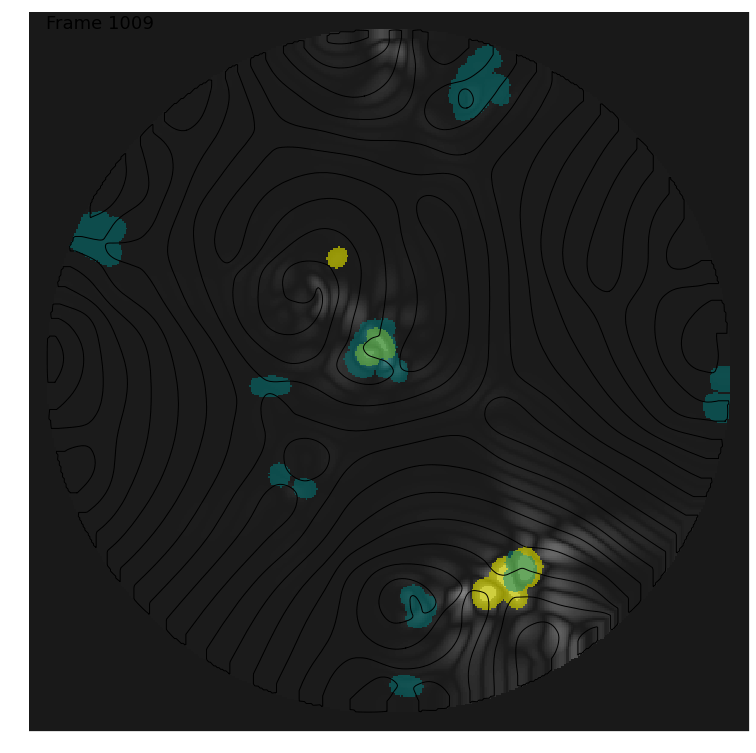

In [13]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) 
fig = plt.figure();
ax = fig.add_subplot(111);
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None);
fig.gca().set_axis_off()

ax.set_xlim([0,im.bmp.shape[0]])
ax.set_ylim([im.bmp.shape[0], 0])

ims = []

for idx in process_range:
    
    print idx

    (plot_layers, plot_contours, stitle) = update_plot(ax, animation_data[idx])
    
    txt_title = ax.annotate(("Frame %d" % idx) + stitle, (10,10), color='black', fontsize=18)
    ax.axis('off')
    ims.append( [layer[0] for layer in plot_layers] + [txt_title] + [contour[0] for contour in plot_contours])

writer = animation.FFMpegWriter(bitrate=2000, fps=10)
anim = animation.ArtistAnimation(fig, ims, blit=True, repeat_delay=350)
anim.save(myproject['directory'] + ('/lyap_cutoff_%0.2f_%d_%d.mp4' % (lyap_diff_cutoff, process_range[0], process_range[-1])), writer=writer)